### Обработка данных и обучение моделей

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.metrics import classification_report, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import joblib
import time
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

### Загрузим данныепо трем городам

In [309]:
bursa = pd.read_excel('train//Bursa.xlsx')
ankara = pd.read_excel('train//ankara.xlsx')
istanbul = pd.read_excel('train//istanbul.xlsx')

In [310]:
bursa = bursa.rename({'Здание': 'build', 'Сеть': 'chain', 'Площадь': 'target_area'}, axis = 1)
ankara = ankara.rename({'Тип здания': 'build', 'Сеть': 'chain', 'Площадь': 'target_area'}, axis = 1)
istanbul = istanbul.rename({'Тип здания (ТЦ/БЦ/другое)': 'build', 'Сеть': 'chain', 'Площадь': 'target_area'}, axis = 1)

In [311]:
features = ['input_id', 'area_building', 'group', 'chain',
               'build', 'category', 'review_count','review_rating', 'images', 'target_area']
bursa = bursa[features]
ankara = ankara[features].dropna(subset = features[2:-3])
istanbul = istanbul[features].dropna(subset = features[2:-3])

In [312]:
cities = pd.concat([bursa, ankara, istanbul], ignore_index=True)

In [427]:
category = cities['category']

In [293]:
for col in cities.columns[2:-4]:
    print(col)
    print()
    print(cities[col].value_counts())
    print('____________')

group

group
Мало отзывов без бассейна     1869
Студия                        1414
Много отзывов без бассейна     650
Другое                         167
Много отзывов + бассейн        132
Мало отзывов + бассейн          64
Name: count, dtype: int64
____________
chain

chain
Нет    3576
Да      468
нет     244
да        8
Name: count, dtype: int64
____________
build

build
Ж               2179
Адм             1386
Другое           261
О                248
ТЦ               157
Гостиница         43
БЦ                21
ТЦ (Магазин)       1
Name: count, dtype: int64
____________
category

category
Gym                             2694
Pilates studio                   948
Fitness center                    81
Physical fitness program          76
Yoga studio                       56
                                ... 
Athletic track                     1
Karate club                        1
Fitness equipment wholesaler       1
Stadium                            1
Hotel                        

### Приведем данные к нужному виду

In [317]:
def to_remake_category(value):
    value = value.lower()
    if value == 'gym' or value == 'fitness center':
        return 'gym'
    if re.search(r'\b(fitness)\b', value):
        return 'fitness'
    elif re.search(r'\b(yoga|gymnastic|pilates|health|dance|shaping|dietitian|spa|diabet|sauna|weight|nutritionist)\b', value):
        return 'yoga'
    elif re.search(r'\b(complex|athletic|stadium)\b', value):
        return 'complex'
    elif re.search(r'\b(court)\b', value):
        return 'court'
    elif 'school' in value:
        return 'school'
    else:
        return 'other'

def to_remake_group(value):
    if 'без' in value:
        return 'no_pool'
    elif 'бассейн' in value:
        return 'pool'
    elif 'студия' in value.lower():
        return 'studio'
    else:
        return 'other'

def to_remake_build(value):
    if value.lower() == 'ж':
        return 'res'
    elif value.lower() == 'адм':
        return 'adm'
    else:
        return 'com'
        

In [318]:
cities['chain'] = cities['chain'].apply(lambda x: 1 if x in ['да', 'Да'] else 0)
cities['category'] = cities['category'].apply(to_remake_category)
cities['group'] = cities['group'].apply(to_remake_group)
cities['build'] = cities['build'].apply(to_remake_build)

In [298]:
for col in cities.columns[2:-4]:
    print(col)
    print()
    print(cities[col].value_counts())
    print('____________')

group

group
no_pool    2519
studio     1414
pool        196
other       167
Name: count, dtype: int64
____________
chain

chain
0    3820
1     476
Name: count, dtype: int64
____________
build

build
res    2179
adm    1386
com     731
Name: count, dtype: int64
____________
category

category
gym        2775
yoga       1040
other       316
school       94
complex      70
court         1
Name: count, dtype: int64
____________


### Посмотрим на корреляции ппризнаков и итоговой площади

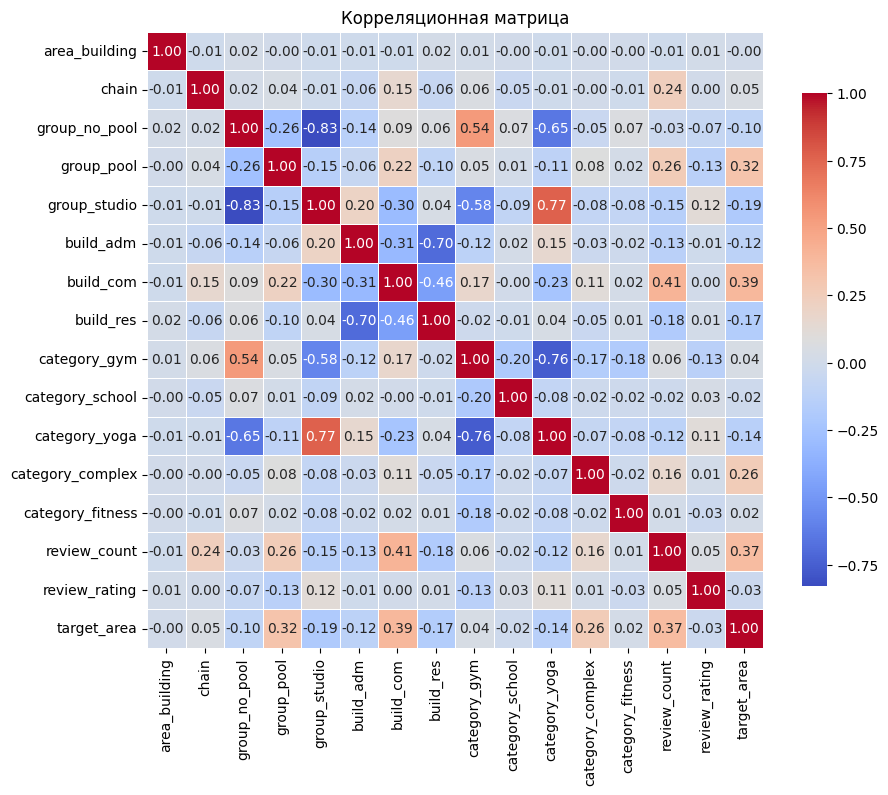

In [319]:
cities_encoded = pd.get_dummies(cities, columns=['group', 'build', 'category'])
cities_encoded = cities_encoded[['input_id', 'area_building', 'chain', 'images',
       'group_no_pool', 'group_pool', 'group_studio', 'build_adm', 'build_com', 'build_res', 'category_gym',
       'category_school', 'category_yoga', 'category_complex', 'category_fitness',
                                 'review_count', 'review_rating', 'target_area']]

cities_encoded[['group_no_pool', 'group_pool', 'group_studio',
               'build_adm', 'build_com', 'build_res',
               'category_gym','category_school',
                'category_yoga', 'category_complex', 'category_fitness',]] = cities_encoded.iloc[:,4:-3].astype('int')
correlation_matrix = round(cities_encoded[['area_building', 'chain', 'group_no_pool',
                                          'group_pool', 'group_studio', 'build_adm', 'build_com',
                                          'build_res', 'category_gym', 'category_school', 'category_yoga',
                                           'category_complex', 'category_fitness',
                                          'review_count', 'review_rating','target_area']].corr(), 2)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, fmt='.2f', linewidths=.5)
plt.title('Корреляционная матрица')
plt.show()

### Данные сильно несбалансированны, что делает задачу регрессии - очень сложной

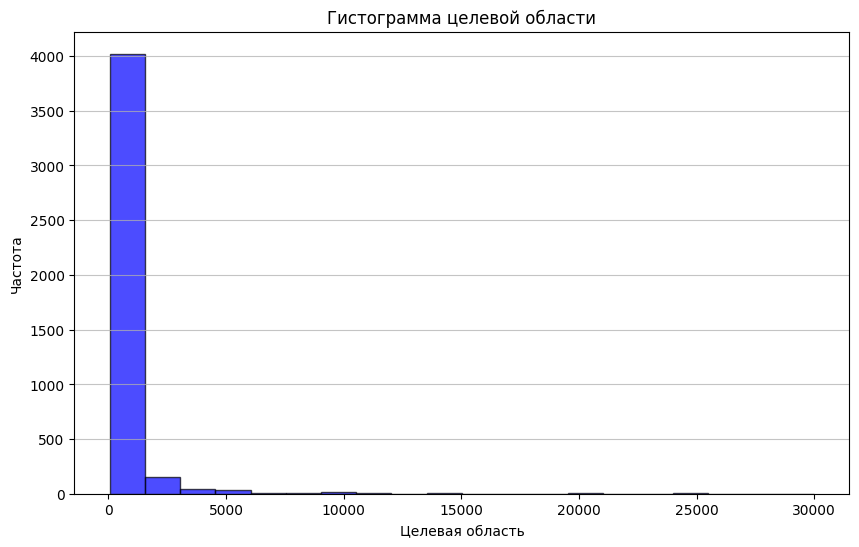

In [93]:
plt.figure(figsize=(10, 6))
plt.hist(cities_encoded['target_area'], bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Гистограмма целевой области')
plt.xlabel('Целевая область')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [94]:
cities_encoded['target_area'].describe()

count     4296.000000
mean       619.350093
std       1764.169015
min         50.000000
25%        150.000000
50%        250.000000
75%        400.000000
max      30000.000000
Name: target_area, dtype: float64

### Обучим RandomForestRegressor
- разделим по квантилям для баллансировки
- предсказывать будем по логарифму, потом переведм обратно

In [95]:
quantiles = cities_encoded['target_area'].quantile([0.0, 0.25, 0.5, 0.75, 1.0]).values
bins = pd.cut(cities_encoded['target_area'], bins=quantiles, include_lowest=True)
cities_encoded['quantile_group'] = bins

samples_per_quantile = 350
balanced_data = cities_encoded.groupby('quantile_group').apply(lambda x: x.sample(min(len(x), samples_per_quantile),
                                                                                  random_state=666)).reset_index(drop=True)
balanced_data = balanced_data.drop(columns='quantile_group')

eatures = [
    # 'chain',
    # 'group_no_pool',
    'group_pool',
    'group_studio',
    'build_adm',
    'build_com',
    'build_res',
    # 'category_gym',
    'category_complex',
    # 'category_yoga',
    'review_count'
]

target = 'target_area'

X = balanced_data[features]
y = balanced_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_leaf=4,
                               warm_start=True, max_features = "log2")
 
model.fit(X_train, np.log1p(y_train))

predictions_log = model.predict(X_test)

y_pred = np.expm1(predictions_log)

absolute_errors = np.abs(y_test - y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(absolute_errors)
medae = np.median(absolute_errors)
maxe = np.max(absolute_errors)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MedAE: {medae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Max error: {maxe:.2f}')

C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\2788788557.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_data = cities_encoded.groupby('quantile_group').apply(lambda x: x.sample(min(len(x), samples_per_quantile),
C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\2788788557.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = cities_encoded.groupby('quantile_group').apply(lambda x: x.sample(min(len(x), samples_per_quantile),


RMSE: 1320.45
MAE: 336.89
MedAE: 66.74
RMSE: 1320.45
Max error: 17550.26


### Обучим RandomForestRegressor только для точек <1000 м2
- разделим по квантилям для баллансировки
- предсказывать будем по логарифму, потом переведм обратно

In [83]:
df = cities_encoded[cities_encoded['target_area']<1000]

quantiles = df['target_area'].quantile([0.0, 0.25, 0.5, 0.75, 1.0]).values
bins = pd.cut(df['target_area'], bins=quantiles, include_lowest=True)
df['quantile_group'] = bins

samples_per_quantile = 350
balanced_data = df.groupby('quantile_group').apply(lambda x: x.sample(min(len(x),
                                                                          samples_per_quantile), random_state=1)).reset_index(drop=True)

balanced_data = balanced_data.drop(columns='quantile_group')

features = [
    # 'chain',
    # 'group_no_pool',
    'group_pool',
    'group_studio',
    'build_adm',
    'build_com',
    'build_res',
    # 'category_gym',
    'category_complex',
    # 'category_yoga',
    'review_count',
]

target = 'target_area'

X = balanced_data[features]
y = balanced_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_leaf=4,
                               warm_start=True, max_features = "log2")
 
model.fit(X_train, np.log1p(y_train))
predictions_log = model.predict(X_test)
y_pred = np.expm1(predictions_log)

absolute_errors = np.abs(y_test - y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(absolute_errors)
medae = np.median(absolute_errors)
maxe = np.max(absolute_errors)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MedAE: {medae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Max error: {maxe:.2f}')

C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\2600004631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quantile_group'] = bins
C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\2600004631.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_data = df.groupby('quantile_group').apply(lambda x: x.sample(min(len(x),
C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\2600004631.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping colum

RMSE: 114.38
MAE: 77.64
MedAE: 50.41
RMSE: 114.38
Max error: 505.94


### Обучим RandomForestRegressor только для точек <5000 м2
- разделим по квантилям для баллансировки
- предсказывать будем по логарифму, потом переведм обратно

In [85]:
df = cities_encoded[cities_encoded['target_area']<5000]

quantiles = df['target_area'].quantile([0.0, 0.25, 0.5, 0.75, 1.0]).values
bins = pd.cut(df['target_area'], bins=quantiles, include_lowest=True)
df['quantile_group'] = bins

samples_per_quantile = 350
balanced_data = df.groupby('quantile_group').apply(lambda x: x.sample(min(len(x), samples_per_quantile), random_state=1)).reset_index(drop=True)

balanced_data = balanced_data.drop(columns='quantile_group')

features = [
    # 'chain',
    # 'group_no_pool',
    'group_pool',
    'group_studio',
    'build_adm',
    'build_com',
    'build_res',
    # 'category_gym',
    'category_complex',
    # 'category_yoga',
    'review_count',
]

target = 'target_area'

X = balanced_data[features]
y = balanced_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_leaf=4,
                               warm_start=True, max_features = "log2")
 
model.fit(X_train, np.log1p(y_train))
predictions_log = model.predict(X_test)
y_pred = np.expm1(predictions_log)

absolute_errors = np.abs(y_test - y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(absolute_errors)
medae = np.median(absolute_errors)
maxe = np.max(absolute_errors)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MedAE: {medae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Max error: {maxe:.2f}')

C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\3065553764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quantile_group'] = bins
C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\3065553764.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balanced_data = df.groupby('quantile_group').apply(lambda x: x.sample(min(len(x), samples_per_quantile), random_state=1)).reset_index(drop=True)
C:\Users\Mariia\AppData\Local\Temp\ipykernel_38888\3065553764.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is d

RMSE: 459.41
MAE: 209.71
MedAE: 65.63
RMSE: 459.41
Max error: 3331.07


### Переключимся на задачу классификации спортивных центров на те, что больше 1000 м2 и меньше 1000 м2
- `1`: > 1000 м2
- `0`: < 1000 м2

In [78]:
cities_encoded['target_class'] = (cities_encoded['target_area']>=1000).astype('int')
start = cities_encoded[cities_encoded['target_class']==0].sample(499, random_state = 42)
end = cities_encoded[cities_encoded['target_class']==1]

df = pd.concat([start, end], axis = 0).reset_index(drop = True)
# Features
features = [
    # 'chain',
    # 'group_no_pool',
    'group_pool',
    'group_studio',
    # 'build_adm',
    'build_com',
    'build_res',
    # 'category_gym',
    'category_complex',
    # 'category_yoga',
    'review_count'
]


X = df[features]
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_leaf=4,
                               warm_start=True, max_features = "log2")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.89
Precision: 0.87
Recall: 0.91
F1 Score: 0.89
ROC AUC: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       155
           1       0.87      0.91      0.89       145

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



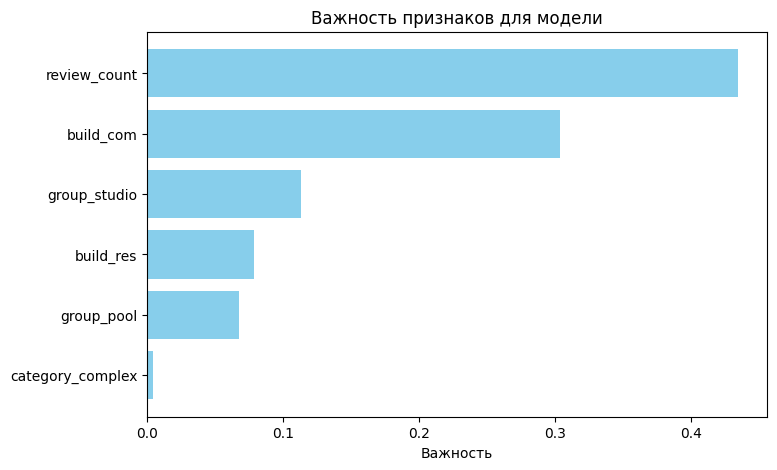

In [75]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color="skyblue")
plt.xlabel("Важность")
plt.title("Важность признаков для модели")
plt.gca().invert_yaxis()
plt.show()

In [79]:
# Посмотрим какую долю оставшихся данных < 1000 м2 модель определит в нужный класс

target_class_0 = cities_encoded[cities_encoded['target_class'] == 0]
sampled_rows = target_class_0.sample(499, random_state=42)
remaining_rows = target_class_0.drop(sampled_rows.index)
y_pred = model.predict(remaining_rows[features])

(len(y_pred) - sum(y_pred))/len(y_pred)

0.8681018799272286

In [74]:
# Сохраняем модель

joblib.dump(model, "model/rf_model_no_photo.pkl")

['model/rf_model_no_photo.pkl']

### В другом ноутбуке мы отфильтровали картинки на полезные и бесполезные в контексте спортивных центров, посчитали разные параметры глубины и применили модель для описания фотографий, используем эти признаки

In [102]:
cities_encoded = pd.read_excel('train//cities_lines_depth.xlsx')

### Решим задачу классификации с помощью `HistGradientBoostingClassifier`, оставляя с google-maps только количество отзывов

In [103]:
start_time = time.time()

start = cities_encoded[cities_encoded['target_class'] == 0].sample(499, random_state=42)
end = cities_encoded[cities_encoded['target_class'] == 1]

df = pd.concat([start, end], axis=0).reset_index(drop=True)

features = [
    'review_count',
    'maxx',
    'floor_14_max',
    'floor_12_max',
    # 'floor_34_max',
    'wall_14_max',
    'wall_12_max',
    'wall_34_max',
    'floor_14_p',
    'floor_12_p',
    # 'floor_34_p',
    'wall_14_p',
    'wall_12_p',
    'wall_34_p',
    'floor_14_std',
    'floor_12_std',
    # 'floor_34_std',
    'wall_14_std',
    'wall_12_std',
    'wall_34_std',
    'floor_14_sum_norm',
    'floor_12_sum_norm',
    # 'floor_34_sum_norm',
    'wall_14_sum_norm',
    'wall_12_sum_norm',
    # 'wall_34_sum_norm'
           ]
# Предобработка текста
X = df[['text_descriptions',
        'review_count', 
        'maxx',
        'floor_14_max',
        'floor_12_max',
        # 'floor_34_max',
        'wall_14_max',
        'wall_12_max',
        'wall_34_max',
        'floor_14_p',
        'floor_12_p',
        # 'floor_34_p',
        'wall_14_p',
        'wall_12_p',
        'wall_34_p',
        'floor_14_std',
        'floor_12_std',
        # 'floor_34_std',
        'wall_14_std',
        'wall_12_std',
        'wall_34_std',
        'floor_14_sum_norm',
        'floor_12_sum_norm',
        # 'floor_34_sum_norm',
        'wall_14_sum_norm',
        'wall_12_sum_norm',
        # 'wall_34_sum_norm'
       ]]
y = df['target_class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

stops_eng = set(stopwords.words('english'))

vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Zа-яА-ЯёЁ]+\b', 
                             stop_words=list(stops_eng), 
                             ngram_range=(1, 3), max_df=0.6, min_df=10)

X_train_text = vectorizer.fit_transform(X_train['text_descriptions'])
X_val_text = vectorizer.transform(X_val['text_descriptions'])

additional_features_train = csr_matrix(X_train[features].values)
combined_features_train = hstack([X_train_text, additional_features_train]).toarray()

additional_features_val = csr_matrix(X_val[features].values)
combined_features_val = hstack([X_val_text, additional_features_val]).toarray()

model = HistGradientBoostingClassifier(random_state=42, max_iter=1000,  learning_rate=0.08, l2_regularization=1, min_samples_leaf=12, warm_start=True)
model.fit(combined_features_train, y_train)

y_pred = model.predict(combined_features_val)

y_proba = model.predict_proba(combined_features_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba[:, 1])

end_time = time.time()
execution_time = end_time - start_time

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Classification Report:')
print(classification_report(y_val, y_pred))
print(f"\nВремя выполнения: {execution_time // 60:.2f} минут")

# Метрики

# Accuracy: 0.85
# Precision: 0.88
# Recall: 0.84
# F1 Score: 0.86
# ROC AUC: 0.91
# Classification Report:
#               precision    recall  f1-score   support

#            0       0.83      0.87      0.85        94
#            1       0.88      0.84      0.86       106

#     accuracy                           0.85       200
#    macro avg       0.85      0.86      0.85       200
# weighted avg       0.86      0.85      0.86       200


# Время выполнения: 0.00 минут

D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Users\Mariia\anaconda\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "D:\Users\Mariia\anaconda\envs\myenv\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\Mariia\anaconda\envs\myenv\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "D:\Users\Mariia\anaconda\envs\myenv\Lib\subprocess.py", line 1540, in _execute_c

Accuracy: 0.85
Precision: 0.88
Recall: 0.84
F1 Score: 0.86
ROC AUC: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        94
           1       0.88      0.84      0.86       106

    accuracy                           0.85       200
   macro avg       0.85      0.86      0.85       200
weighted avg       0.86      0.85      0.86       200


Время выполнения: 1.00 минут


In [104]:
target_class_0 = cities_encoded[cities_encoded['target_class'] == 0]
sampled_rows = target_class_0.sample(499, random_state=42)
rr = target_class_0.drop(sampled_rows.index).reset_index(drop=True)


rr_text = vectorizer.transform(rr['text_descriptions'])

additional_features_rr = csr_matrix(rr[features].values)
combined_features_rr = hstack([rr_text, additional_features_rr]).toarray()

y_pred = model.predict(combined_features_rr)

(len(y_pred) - sum(y_pred))/len(y_pred)

0.8311097634930261

In [108]:
# Сохраняем модель

joblib.dump(model, "model/bosting_model_photo-reviews.pkl")

['model/bosting_model_photo-reviews.pkl']

In [110]:
# Сохраняем векторизатор

joblib.dump(vectorizer, 'model/vectorizer_photo-reviews.joblib')

['model/vectorizer_photo-reviews.joblib']

In [111]:
start_time = time.time()

start = cities_encoded[cities_encoded['target_class'] == 0].sample(499, random_state=42)
end = cities_encoded[cities_encoded['target_class'] == 1]

df = pd.concat([start, end], axis=0).reset_index(drop=True)

features = [
    'group_pool',
    'group_studio',
    'review_count',
    'maxx',
    'floor_14_max',
    'floor_12_max',
    # 'floor_34_max',
    'wall_14_max',
    'wall_12_max',
    'wall_34_max',
    'floor_14_p',
    'floor_12_p',
    # 'floor_34_p',
    'wall_14_p',
    'wall_12_p',
    'wall_34_p',
    'floor_14_std',
    'floor_12_std',
    # 'floor_34_std',
    'wall_14_std',
    'wall_12_std',
    'wall_34_std',
    'floor_14_sum_norm',
    'floor_12_sum_norm',
    # 'floor_34_sum_norm',
    'wall_14_sum_norm',
    'wall_12_sum_norm',
    # 'wall_34_sum_norm'
           ]

X = df[['text_descriptions',
        'group_pool',
        'group_studio',
        'review_count', 
        'maxx',
        'floor_14_max',
        'floor_12_max',
        # 'floor_34_max',
        'wall_14_max',
        'wall_12_max',
        'wall_34_max',
        'floor_14_p',
        'floor_12_p',
        # 'floor_34_p',
        'wall_14_p',
        'wall_12_p',
        'wall_34_p',
        'floor_14_std',
        'floor_12_std',
        # 'floor_34_std',
        'wall_14_std',
        'wall_12_std',
        'wall_34_std',
        'floor_14_sum_norm',
        'floor_12_sum_norm',
        # 'floor_34_sum_norm',
        'wall_14_sum_norm',
        'wall_12_sum_norm',
        # 'wall_34_sum_norm'
       ]]
y = df['target_class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

stops_eng = set(stopwords.words('english'))

vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Zа-яА-ЯёЁ]+\b', 
                             stop_words=list(stops_eng), 
                             ngram_range=(1, 3), max_df=0.6, min_df=10)

X_train_text = vectorizer.fit_transform(X_train['text_descriptions'])
X_val_text = vectorizer.transform(X_val['text_descriptions'])

additional_features_train = csr_matrix(X_train[features].values)
combined_features_train = hstack([X_train_text, additional_features_train]).toarray()

additional_features_val = csr_matrix(X_val[features].values)
combined_features_val = hstack([X_val_text, additional_features_val]).toarray()

model = HistGradientBoostingClassifier(random_state=42, max_iter=1000,  learning_rate=0.08, l2_regularization=1, min_samples_leaf=12, warm_start=True)
model.fit(combined_features_train, y_train)

y_pred = model.predict(combined_features_val)

y_proba = model.predict_proba(combined_features_val)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba[:, 1])

end_time = time.time()
execution_time = end_time - start_time

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')
print('Classification Report:')
print(classification_report(y_val, y_pred))
print(f"\nВремя выполнения: {execution_time // 60:.2f} минут")

Accuracy: 0.85
Precision: 0.87
Recall: 0.84
F1 Score: 0.86
ROC AUC: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        94
           1       0.87      0.84      0.86       106

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.85      0.85      0.85       200


Время выполнения: 1.00 минут


In [112]:
target_class_0 = cities_encoded[cities_encoded['target_class'] == 0]
sampled_rows = target_class_0.sample(499, random_state=42)
rr = target_class_0.drop(sampled_rows.index).reset_index(drop=True)


rr_text = vectorizer.transform(rr['text_descriptions'])

additional_features_rr = csr_matrix(rr[features].values)
combined_features_rr = hstack([rr_text, additional_features_rr]).toarray() 

y_pred = model.predict(combined_features_rr)

(len(y_pred) - sum(y_pred))/len(y_pred)

0.8432383262583384

In [113]:
# Сохраняем модель

joblib.dump(model, "model/bosting_model_photo-reviews-ps.pkl")

['model/bosting_model_photo-reviews-ps.pkl']

In [114]:
# Сохраняем векторизатор

joblib.dump(vectorizer, 'model/vectorizer_photo-reviews-ps.joblib')

['model/vectorizer_photo-reviews-ps.joblib']